In [136]:
from model import *
from dataset import *


seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

torch.set_default_tensor_type(torch.DoubleTensor)

device = 'cpu'

p = 5
embd_dim = 5
input_token = 3
lattice_dim = 2
vocab_size = p ** lattice_dim

#model_mode = 'standard'
#model_mode = 'ip'
model_mode = 'hs1'

if model_mode == 'ip':
    # ip model
    unembd = True
    weight_tied = True
    hidden_size = 100
    shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
    model = MLP(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, unembd=unembd, weight_tied=weight_tied, seed=seed).to(device)
elif model_mode == 'hs2':
    weight_tied = True
    hidden_size = 100
    shp = [input_token * embd_dim, embd_dim, vocab_size]
    model = MLP_HS(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, weight_tied=weight_tied, seed=seed).to(device)
elif model_mode == 'hs1':
    weight_tied = True
    hidden_size = 100
    shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
    model = MLP_HS(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, weight_tied=weight_tied, seed=seed).to(device)
elif model_mode == 'standard':
    unembd = False
    weight_tied = False
    hidden_size = 100
    shp = [input_token * embd_dim, hidden_size, vocab_size]
    model = MLP(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, unembd=unembd, weight_tied=weight_tied, seed=seed).to(device)
else:
    print('model_mode not recognized!')
    
    
# data
dataset = parallelogram_dataset(p=p, dim=lattice_dim, num=1000, seed=seed)
dataset = repeat_dataset(dataset)

### train ###
wd = 0.0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=wd)
steps = 4001 #4001
log = 200

train_losses = []
test_losses = []
train_accs = []
test_accs = []

embds = []

lamb = 1.

for step in range(steps):
        
    optimizer.zero_grad()
    
    logits = model.pred_logit(dataset['train_data_id'])
    loss = torch.nn.functional.cross_entropy(logits, dataset['train_label'])
    
    embd_reg = torch.mean(torch.sqrt(torch.mean(model.embedding**2, dim=0)))
    total_loss = loss + lamb * embd_reg
    
    acc = torch.mean((torch.argmax(logits, dim=1) == dataset['train_label']).float())

    train_losses.append(loss.item())
    train_accs.append(acc.item())
    
    logits_test = model.pred_logit(dataset['test_data_id'])
    loss_test = torch.nn.functional.cross_entropy(logits_test, dataset['test_label'])

    acc_test = torch.mean((torch.argmax(logits_test, dim=1) == dataset['test_label']).float())

    test_losses.append(loss_test.item())
    test_accs.append(acc_test.item())

    #total_loss = loss
    total_loss.backward()
    optimizer.step()

    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | train acc: %.2e | test acc: %.2e "%(step, total_loss.cpu().detach().numpy(), loss.cpu().detach().numpy(), loss_test.cpu().detach().numpy(), acc.cpu().detach().numpy(), acc_test.cpu().detach().numpy()))
 
    if step % 100 == 0:
        embds.append(model.embedding.cpu().detach().numpy())

step = 0 | total loss: 3.73e+00 | train loss: 3.53e+00 | test loss 3.53e+00 | train acc: 3.80e-02 | test acc: 3.80e-02 
step = 200 | total loss: 2.62e+00 | train loss: 2.46e+00 | test loss 2.46e+00 | train acc: 3.13e-01 | test acc: 3.13e-01 
step = 400 | total loss: 2.02e-01 | train loss: 6.18e-02 | test loss 6.18e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 600 | total loss: 1.54e-01 | train loss: 3.18e-02 | test loss 3.18e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 800 | total loss: 1.43e-01 | train loss: 3.77e-02 | test loss 3.77e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 1000 | total loss: 1.36e-01 | train loss: 4.22e-02 | test loss 4.22e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 1200 | total loss: 1.31e-01 | train loss: 4.34e-02 | test loss 4.34e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 1400 | total loss: 1.23e-01 | train loss: 4.25e-02 | test loss 4.25e-02 | train acc: 1.00e+00 | test acc: 1.00e+00 
step = 1600 | total los

Sample complexity is interesting (study dependence on num)! It seems that hs is more sample efficient than ip and standard!
Embd_dim is also an important hyperparam. Different methods need different lamb as well.

In [137]:
import numpy as np
from sklearn.decomposition import PCA
embd = model.embedding.cpu().detach().numpy()
X = embd
pca = PCA(n_components=embd_dim)
pca.fit(X)
embd_t = pca.fit_transform(X)

In [138]:
pca.explained_variance_ratio_

array([5.01204439e-01, 4.98795550e-01, 8.41610968e-09, 1.67171525e-09,
       9.22016930e-10])

In [139]:
active_pca_dim = np.sum(pca.explained_variance_ratio_ > 1e-4)

In [140]:
torch.mean(model.embedding**2, dim=0)

tensor([7.5842e-10, 1.1971e-09, 9.4570e-10, 3.5628e-02, 3.5727e-02],
       grad_fn=<MeanBackward1>)

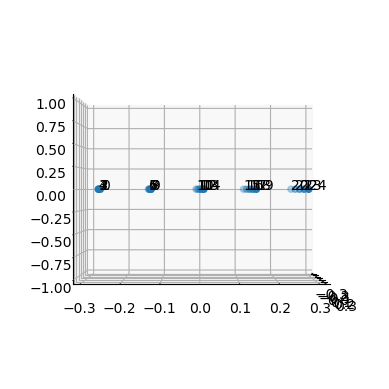

In [153]:
#%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpld3

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Data for the plot (example)
x = embd_t[:,0]
y = embd_t[:,1]
z = embd_t[:,2]

ax.scatter(x, y, z)

ax.set_zlim(-1,1)

# Add text annotation
for i in range(25):
    ax.text(embd_t[i,0], embd_t[i,1], embd_t[i,2], i, color='black')

#plt.show()
ax.view_init(0,0)

In [106]:
active_embd_dim = torch.sum(torch.mean(model.embedding**2, dim=0) > 1e-4).item()

In [97]:
active_pca_dim, active_embd_dim

(3, 4)

In [98]:
inputs = embd[dataset['train_data_id']]
output = (- inputs[:,0,:] + inputs[:,1,:] + inputs[:,2,:])

xx = np.linalg.norm(output, axis=1)[:,None]**2
ww = np.linalg.norm(embd, axis=1)[None,:]**2
wx = output @ embd.T
distsq = ww + xx - 2 * wx
acc = np.mean(np.argmin(distsq, axis=1) == dataset['train_label'].cpu().detach().numpy())

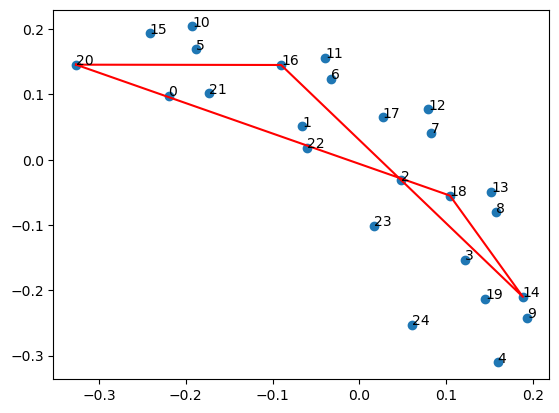

In [100]:
import copy
import matplotlib.pyplot as plt

embd = model.embedding.cpu().detach().numpy()

dim1 = 0
dim2 = 1

plt.scatter(embd[:,dim1], embd[:,dim2])


for i in range(p**2):
    plt.text(embd[i,dim1], embd[i,dim2], i)
    
i = 0
dp = torch.cat([dataset['train_data_id'][[i]], dataset['train_label'][[i]][:,None]], dim=1)[0]
cor = embd[dp.cpu().detach().numpy()][:,[dim1, dim2]]
cor2 = copy.deepcopy(cor[2])
cor3 = copy.deepcopy(cor[3])
cor[2] = cor3
cor[3] = cor2
cor = np.concatenate([cor, cor[[0],:]], axis=0)
plt.plot(cor[:,0], cor[:,1], color='red')

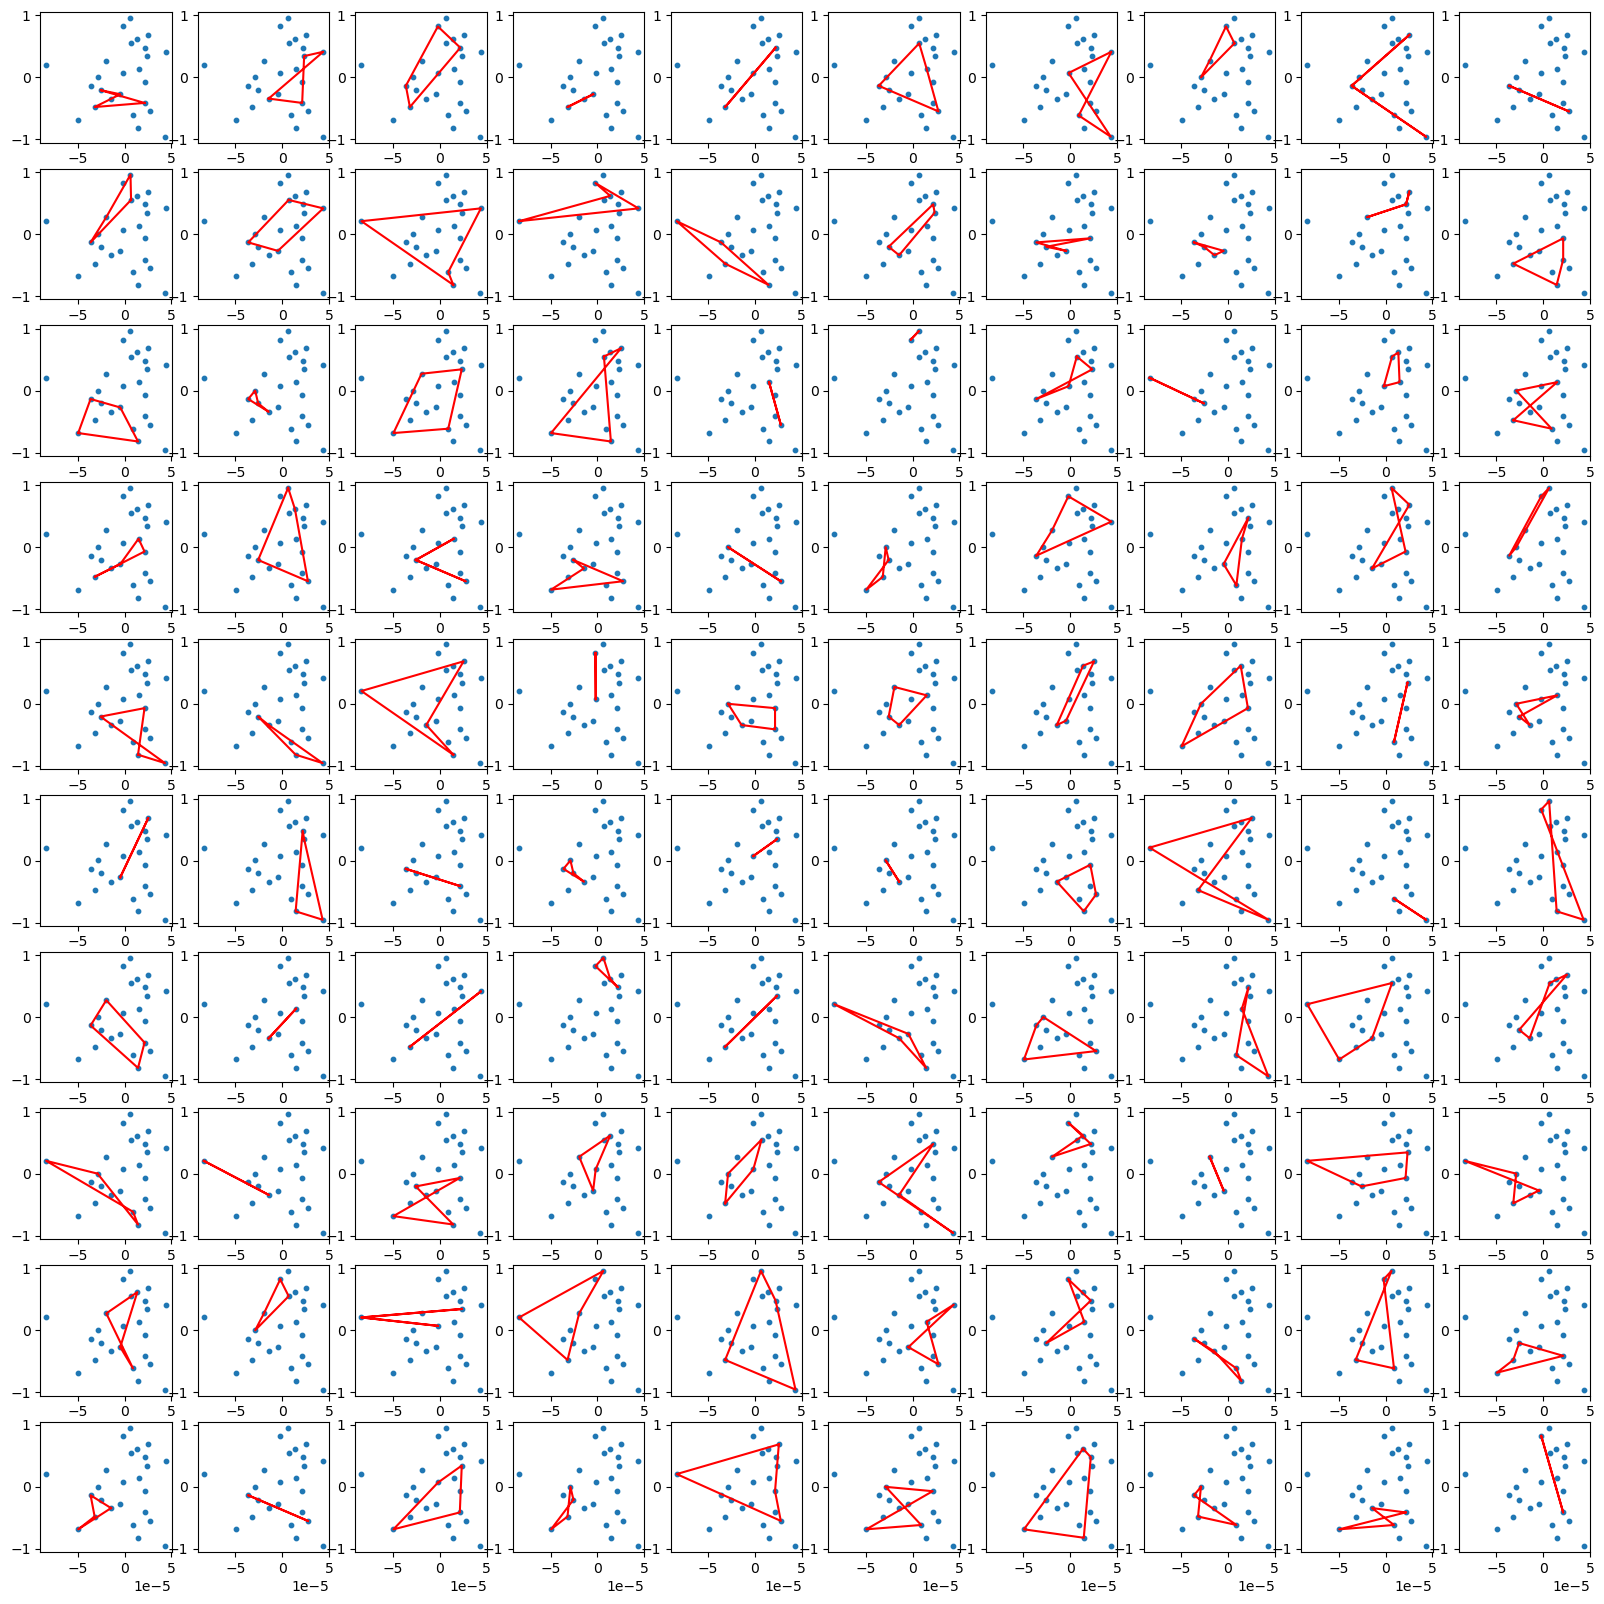

In [29]:
#plt.subplot(10,10,1)
import copy

plt.figure(figsize=(20,20))

dim1 = 0
dim2 = 1

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.scatter(embd[:,dim1], embd[:,dim2], s=10)
    dp = torch.cat([dataset['train_data_id'][[i]], dataset['train_label'][[i]][:,None]], dim=1)[0]
    cor = embd[dp.cpu().detach().numpy()][:,[dim1, dim2]]
    cor2 = copy.deepcopy(cor[2])
    cor3 = copy.deepcopy(cor[3])
    cor[2] = cor3
    cor[3] = cor2
    cor = np.concatenate([cor, cor[[0],:]], axis=0)
    plt.plot(cor[:,0], cor[:,1], color='red')

In [29]:
# analyze data
import numpy as np
import matplotlib.pyplot as plt

#model_mode = 'standard'
#model_mode = 'hs1'
model_mode = 'ip'

#embd_dims = [1,2,3,4,5,10,20,50,100]
#embd_dims = [1,2,3,4,5,10,20]
embd_dims = [2,5,20]
data_nums = [10,20,50,100,200,500,1000,2000,5000,10000]
#data_nums = [10,20,50,100,200,500,1000,2000]
lamb = 0.0
seed = 0

train_accss = []
p_accss = []
pca_dimss = []

for embd_dim in embd_dims:
    train_accs = []
    p_accs = []
    pca_dims = []
    for data_num in data_nums:

        data = np.loadtxt('./results/lattice/model_%s_embddim_%d_data_%d_lamb_%.2f_seed_%d_p_10_performance.txt'%(model_mode, embd_dim, data_num, lamb, seed))
        train_accs.append(data[0])
        p_accs.append(data[2])
        pca_dims.append(data[3])
        
    train_accss.append(train_accs)
    p_accss.append(p_accs)
    pca_dimss.append(pca_dims)

Text(0.5, 0.98, 'MLP (inner product)')

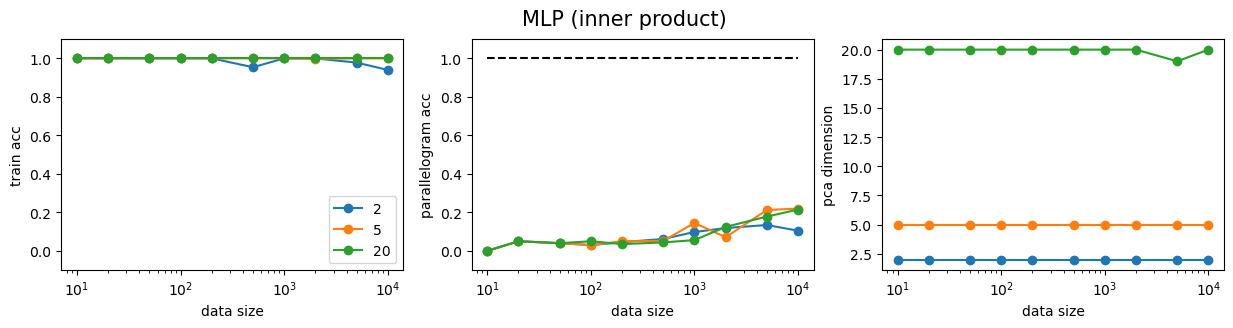

In [30]:
plt.figure(figsize=(15,3))

plt.subplot(1,3,1)

for i in range(len(train_accss)):
    plt.plot(data_nums, train_accss[i], marker='o')
    
plt.legend(embd_dims, loc='lower right')
plt.xlabel('data size')
plt.ylabel('train acc')
plt.xscale('log')
plt.ylim(-0.1,1.1)

plt.subplot(1,3,2)

for i in range(len(train_accss)):
    plt.plot(data_nums, p_accss[i], marker='o')
    
plt.plot(data_nums, np.array(p_accss[i])*0+1, ls='--', color='black')
    
plt.xlabel('data size')
plt.ylabel('parallelogram acc')
plt.xscale('log')
plt.ylim(-0.1,1.1)

plt.subplot(1,3,3)

for i in range(len(train_accss)):
    plt.plot(data_nums, pca_dimss[i], marker='o')
    
plt.xlabel('data size')
plt.ylabel('pca dimension')
plt.xscale('log')


#plt.suptitle('MLP (harmonic similarity)', fontsize=15)
plt.suptitle('MLP (inner product)', fontsize=15)
#plt.suptitle('MLP (standard)', fontsize=15)